<a href="https://colab.research.google.com/github/JohanEstebanCuervo/Color_Reproduction_Multiespectral_Images/blob/main/Pulse_Amplitude_Modulation_PAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias a utilizar

In [3]:
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg 
from math import ceil
from commpy.modulation import QAMModem
from commpy.filters import rrcosfilter
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

# Funciones 

In [40]:
def Grafica_Pulse_Shaping(X,Y,title,legend=None):
  colores = ['black','green','purple','gray',]
  plt.figure(figsize=(16,9))
  plt.title(title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()

  if legend is None:
    legend=[]
    for i in range(len(X)):
      legend.append('None')

  for i,x in enumerate(X):
    y = Y[i]
    plt.plot(x,y,color=colores[i],label=legend[i])
    inicial = []
    t_i = []
    finales = []
    t_f = []
    for j,val in enumerate(x):
      if val%1==0:
        inicial.append(y[j])
        t_i.append(val)
      else:
        finales.append(y[j])
        t_f.append(val)

    
    markerline, stemlines, baseline = plt.stem(t_i,inicial, linefmt ='red', markerfmt ='D')
    plt.setp(baseline, 'linewidth', 1,'color','gray')
    plt.setp(markerline, markersize=10)
    markerline.set_markerfacecolor(colores[i]) 
    markerline.set_markeredgecolor(colores[i])

    markerline, stemlines, baseline = plt.stem(t_f,finales, linefmt ='gray')
    markerline.set_markerfacecolor('gray') 
    markerline.set_markeredgecolor('gray')
    plt.setp(baseline, 'linewidth', 1,'color','gray')


  if legend[0]!='None':
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',fontsize = 14)

  plt.show()

def Grafica_PSD(signal,Fs,title='Espectro de Potencia'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  plt.figure(figsize=(16,9))
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title(title,fontsize = 20)
  plt.grid()
  plt.show()

def eyediagram(signal,muestras_simbolo,title='Diagrama de ojo'):

  inicio=muestras_simbolo//2+1

  plt.figure(figsize=(16,9))
  plt.title(title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()

  signal=np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

def Grafica_PSD_eyediagram(signal,Fs,muestras_simbolo,title='Señal'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  fig= plt.figure(figsize=(25,6))
  plt.subplot(1,2,1)
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title('Espectro de Potencia '+ title,fontsize = 20)
  plt.grid()

  plt.subplot(1,2,2)
  inicio=muestras_simbolo//2+1
  plt.title('Diagrama de ojo ' + title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()
  signal = np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

  plt.show

def upsample(signal,N):

  y = np.zeros(len(signal)*N)

  for i in range(len(signal)):

    y[i*N] = signal[i]

  return y

def bintodecimal(X,n,relleno='antes'):

  if len(X)%n!=0:

    if relleno =='antes':
      X = np.concatenate((np.zeros(n-len(X)%n),X)).astype(int)

    if relleno =='despues':
      X = np.concatenate((X,np.zeros(n-len(X)%n))).astype(int)

  X = np.reshape(X,(-1,n))*2
  res = np.copy(X[:,-1])//2
  X = np.power(X,np.flip(np.arange(n)))

  X[:,-1]=X[:,-1]*res

  X = np.sum(X,axis=1).astype(int)

  return X

  

#PULSE AMPLITUDE MODULATION

**BIT:** Elemento abstracto de información que representa unicamente dos estados: abierto-cerrado, vacio-lleno, negro-blanco. Generalmente en nuestra rama de estudio un 1 - 0.

**SÍMBOLO:** Elemento abstracto que representa información. En las comunicaciones un simbolo representa  generalmente una cantidad *N* de bits. Un simbolo puede hacer referencia a un color, amplitud, longitud de onda, fase, forma, etc. En general cualquier elemento que utilice para representar información.

**TASA DE TRANSMISIÓN DE BIT:** Cantidad de bits que se transmiten por segundo en una comunicación. dado en bit/s ó bps, ejemplo: 100Mbps, 3kbps

**TASA DE MUESTREO:** Es la Cantidad de muestras que representan un bit o símbolo, multiplicado por la tasa de transmisión de bits o símbolos por segundo, según sea el caso. ejemplo:

N= Muestras por bit
$$N=10$$
S= Velocidad de transmisión de bit
$$S= 2Mbps$$

$$T_M=N*S= 10 * 2Mbps$$
$$T_M= 20Mmuestras/s$$

**FORMA DE PULSO:** Es la forma que van a adquirir los bits o simbolos para sen transmitidos. En nuestro caso de estudio las dos formas de pulso de interes son pulso cuadrado y filtro del coseno realzado (RRC).

1. Pulso Cuadrado: Es la forma clásica de pulso para realizarla en python:



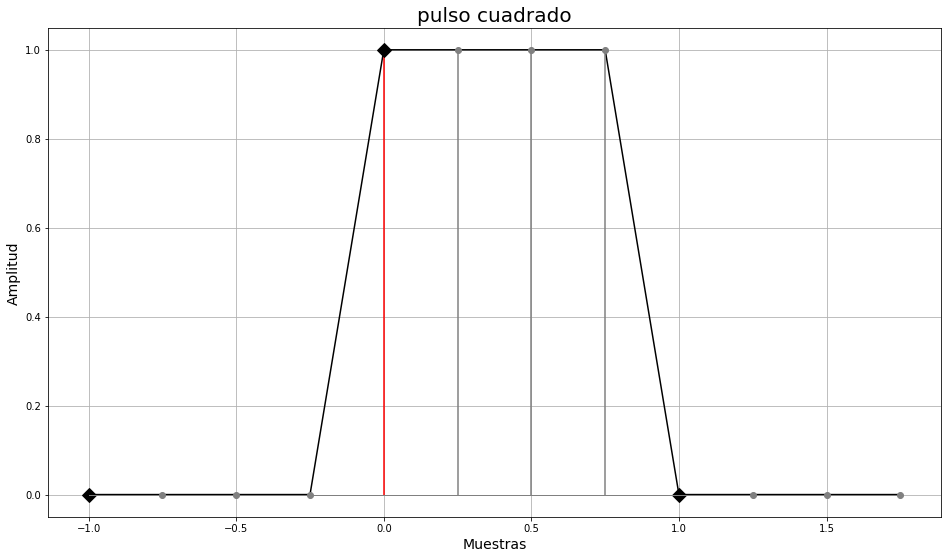

In [6]:
muestras_simbolo= 4

ps = np.concatenate((np.zeros(muestras_simbolo),np.ones(muestras_simbolo),np.zeros(muestras_simbolo)))
ts = np.linspace(-1,1+(muestras_simbolo-1)/muestras_simbolo,muestras_simbolo*3)

Grafica_Pulse_Shaping([ts],[ps],'pulso cuadrado')

En este ejemplo las barras rojas con símbolo en Rombo, representa la primera muestra de cada bit, en este caso se grafica las muestras anteriores y siguientes al pulso, en nuestro caso el 0. Como es natural el pulso cuadrado no influye en las muestras de los demás bits.

2. Filtro Raiz del coseno realzado:

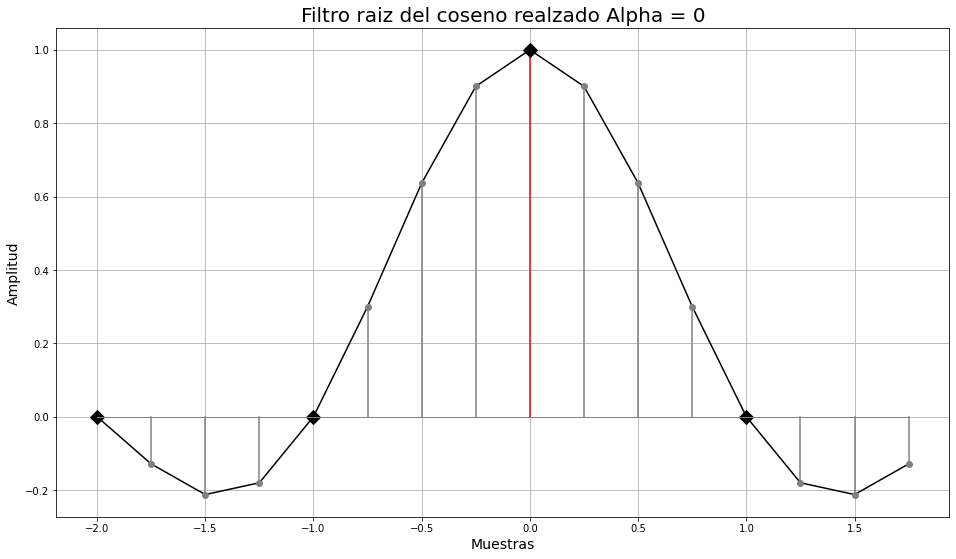

In [7]:
longitud_filtro_s= 4 # longitud del filtro en simbolos     ####Nota: Numeros pares #######
longitud_filtro_m = longitud_filtro_s*muestras_simbolo  #Longitud del filtro en Muestras
alpha = 0 # Factor de caida del filtro
Ts =1 # Periodo del simbolo en segundos tasa de transmision de bit ^-1

Fs = muestras_simbolo/Ts  #Frecuencia de muestreo
RRC = rrcosfilter(longitud_filtro_m, alpha=alpha, Ts=Ts, Fs=Fs)

Grafica_Pulse_Shaping([RRC[0]],[RRC[1]],'Filtro raiz del coseno realzado Alpha = '+str(alpha))

En esta Gráfica se ve la forma del pulso para RRC. En este caso la forma de bit si afecta las muestras de los bits vecinos. Para nuestro caso de Alpha = 0 se puede observar que las primeras muestras de cada bit no se ven afectadas. Además en el proceso de diseño se puede escoger el número de bits que afecte la forma de pulso.

El factor Alpha afecta el ancho del lóbulo principal, Además también afecta el impacto en la muestra inicial de los bits vecinos.


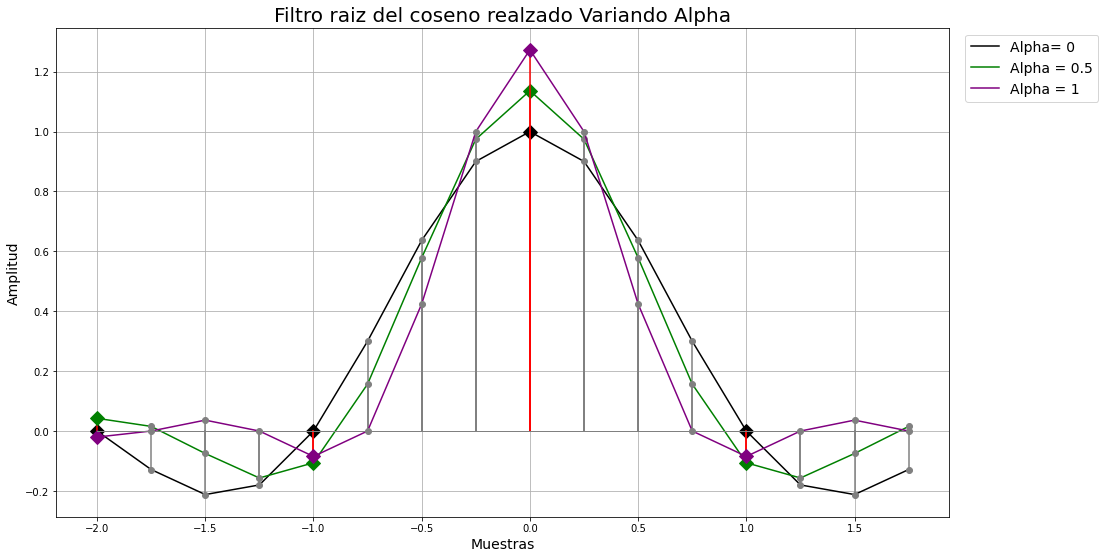

In [8]:
alpha = 0.5 # Modificando Alpha
RRC1 = rrcosfilter(longitud_filtro_m, alpha=alpha, Ts=Ts, Fs=Fs)
alpha = 1 # Modificando Alpha
RRC2 = rrcosfilter(longitud_filtro_m, alpha=alpha, Ts=Ts, Fs=Fs)
Grafica_Pulse_Shaping([RRC[0],RRC1[0],RRC2[0]],[RRC[1],RRC1[1],RRC2[1]],'Filtro raiz del coseno realzado Variando Alpha',legend=['Alpha= 0','Alpha = 0.5','Alpha = 1'])

En la gráfica anterior se puede observar el efecto de Alpha. Al aumentar alpha mayor es el efecto causado en las muestras iniciales de cada bit

**ROLL-OFF:** El valor roll-off llamado en la librería de commpy Alpha, afecta el ancho del lóbulo principal y el efecto causado en las primeras muestras de cada bit o símbolo.
 
- Los efectos en el espacio de la frecuencia es que en un roll-off más pequeño más angosto es el ancho de banda del espectro. Igualmente entre mayor sea el roll-off mayor es el ancho de banda. llegando hasta dos veces la tasa de transmisión de símbolos.
 
- El efecto en el espacio del tiempo es que afecta el bit inicial de cada muestra pero a su vez 'abre' más el ojo en el diagrama de ojos.
 
**SPAN:** El span es el número de símbolos que afecta la forma de pulso. 
 
- Los efectos en el espacio de frecuencia es que al esta ser una señal finita es como realizar la convolución de la respuesta en frecuencia de una pulso cuadrado por la del seno realzado. Por lo cual para un span mayor más angosto será el espectro de potencia y viceversa.
 
- Los efectos en el espacio de tiempo es que afecta más bits vecinos por lo cual dificulta la decodificación de la información recibida.


**MODULACIÓN POR AMPLITUD DE PULSO MULTI-NIVEL:** La amplitud por pulso multinivel es asignar más de dos valores diferentes de amplitud a cada símbolo. Pudiendo de esta manera aumentar el número de bits que se transmiten por símbolo.

[0 0 1 0 1 1 1 0 1]


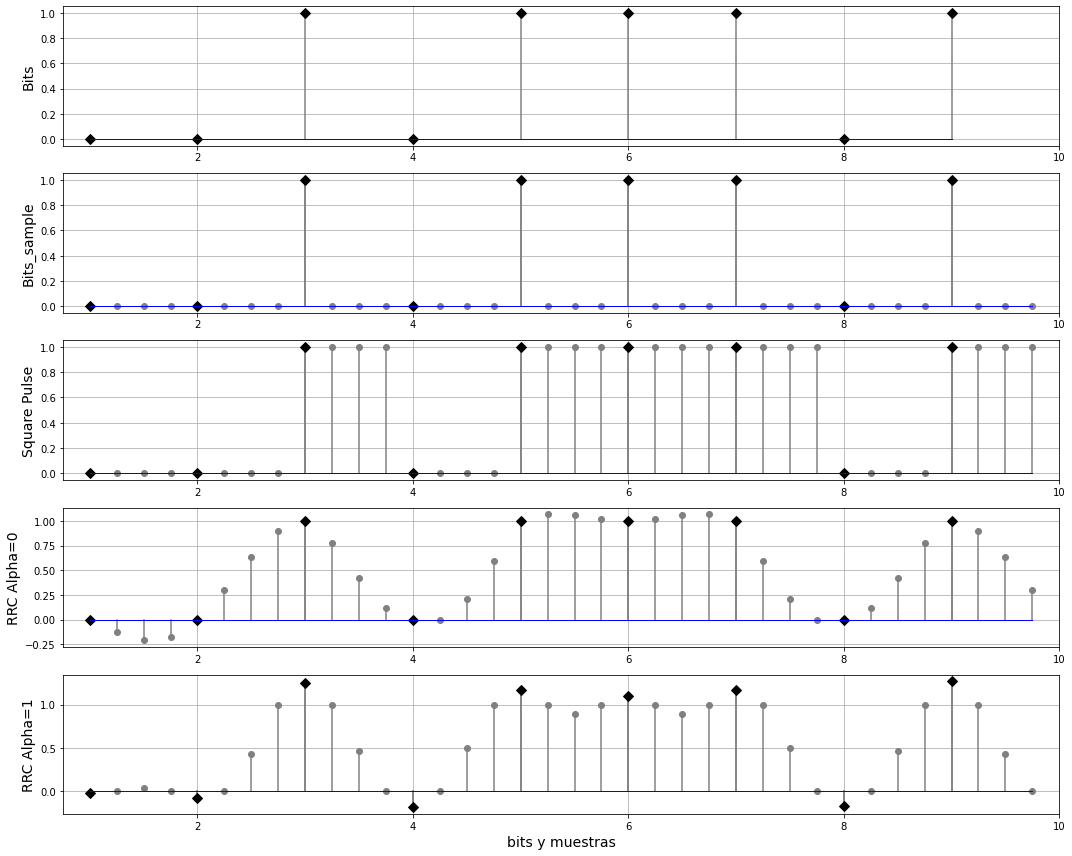

In [16]:
Nbits = 9 #numero de bits
bits = np.random.randint(0,2,Nbits) #Señal binaria de 6 bits
#bits = np.ones(Nbits)  para solo 1
bits_sample = upsample(bits, muestras_simbolo)
t_s = np.linspace(1,Nbits+(muestras_simbolo-1)/muestras_simbolo,Nbits*muestras_simbolo)
t_b = range(1,len(bits)+1)

s_ps = np.convolve(bits_sample,ps)[int(muestras_simbolo):-int(muestras_simbolo*2-1)]
inicial= int(longitud_filtro_s/2*muestras_simbolo)
final = -(inicial-1)
s_RRC = np.convolve(bits_sample,RRC[1])[inicial:final]
s_RRC2 = np.convolve(bits_sample,RRC2[1])[inicial:final]
print(bits)


fig = plt.figure(figsize=(15,12))

################## Primer plot Bits ##########################################
plt.subplot(5,1,1)
markerline, stemlines, baseline =plt.stem(t_b, bits, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')
plt.ylabel('Bits',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()


#################  Segundo plot bits sampleados #########################################
plt.subplot(5,1,2)
markerline, stemlines, baseline =plt.stem(t_s, bits_sample, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= bits_sample[np.linspace(0,muestras_simbolo*(Nbits-1),Nbits).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.ylabel('Bits_sample',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()

##################### Tercer plot pulsos cuadrados ############################################
plt.subplot(5,1,3)
markerline, stemlines, baseline =plt.stem(t_s, s_ps, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_ps[np.linspace(0,muestras_simbolo*(Nbits-1),Nbits).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.ylabel('Square Pulse',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()


####################### Cuarto plot RRC alpha=0 ######################################################
plt.subplot(5,1,4)
markerline, stemlines, baseline =plt.stem(t_s, s_RRC, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_RRC[np.linspace(0,muestras_simbolo*(Nbits-1),Nbits).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')
plt.ylabel(r'RRC Alpha=0',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()

fig.tight_layout()

####################### Cuarto plot RRC alpha=1 ######################################################

plt.subplot(5,1,5)
markerline, stemlines, baseline =plt.stem(t_s, s_RRC2, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_RRC2[np.linspace(0,muestras_simbolo*(Nbits-1),Nbits).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.xlabel('bits y muestras',fontsize = 14)
plt.ylabel(r'RRC Alpha=1',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()

fig.tight_layout()







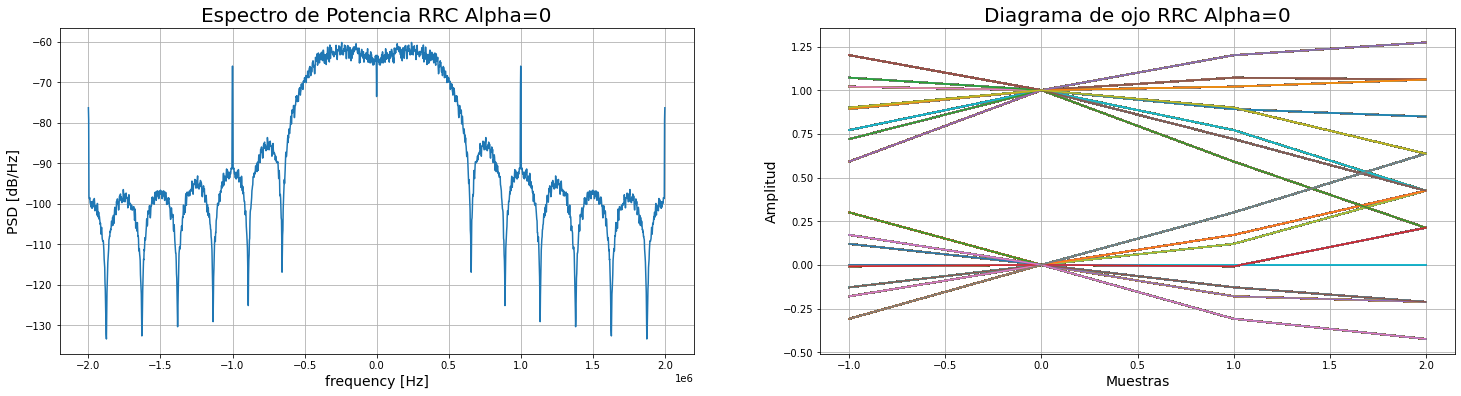

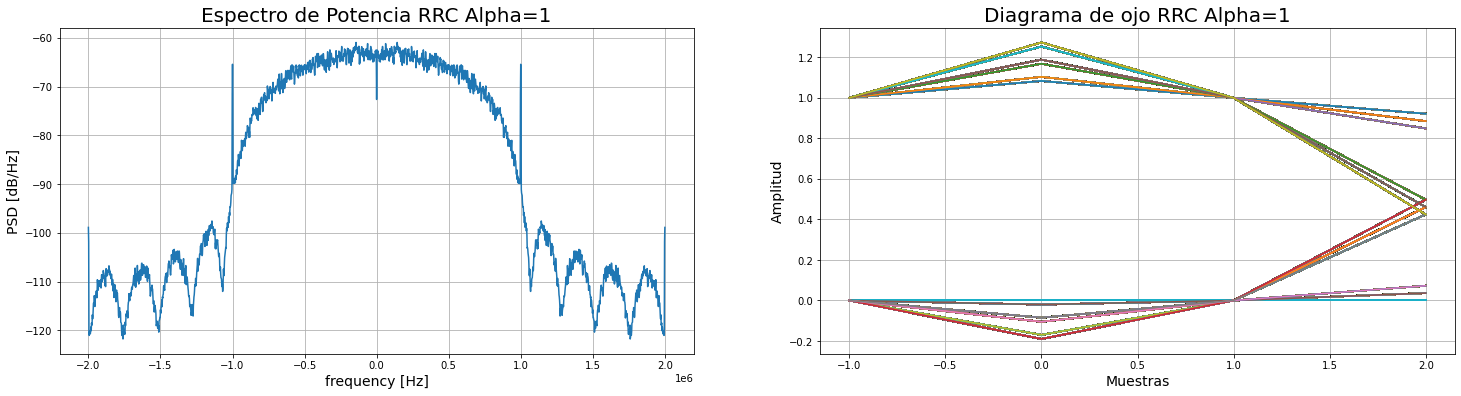

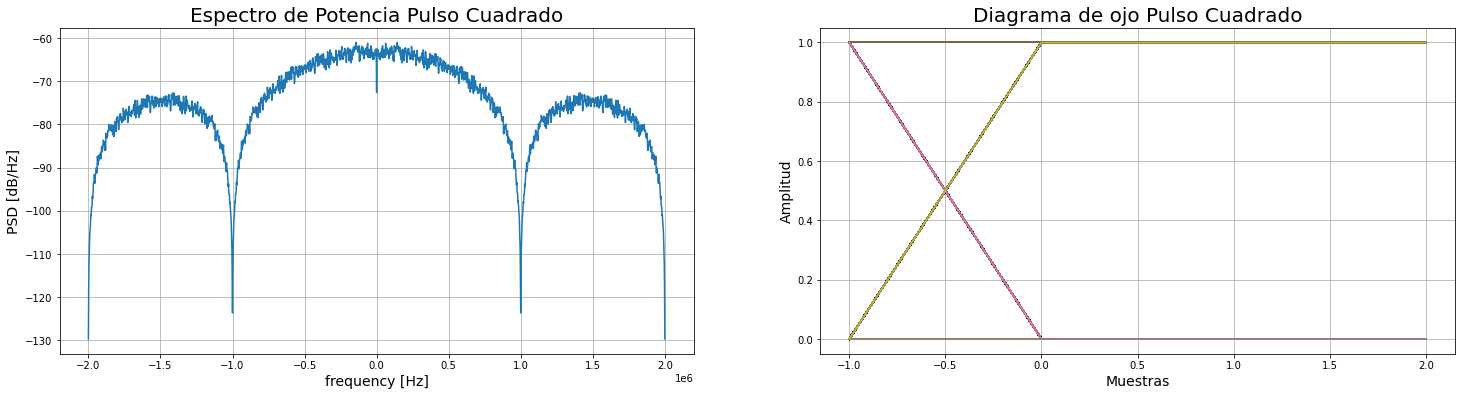

In [10]:
Nbits = 5000 #numero de bits
bits = np.random.randint(0,2,Nbits) #Señal binaria de 6 bits
#bits = np.ones(Nbits)  para solo 1
bits_sample = upsample(bits, muestras_simbolo)
t_s = np.linspace(1,Nbits+(muestras_simbolo-1)/muestras_simbolo,Nbits*muestras_simbolo)
t_b = range(1,len(bits)+1)

s_ps = np.convolve(bits_sample,ps)[int(muestras_simbolo):-int(muestras_simbolo*2-1)]
inicial= int(longitud_filtro_s/2*muestras_simbolo)
final = -(inicial-1)
s_RRC = np.convolve(bits_sample,RRC[1])[inicial:final]
s_RRC2 = np.convolve(bits_sample,RRC2[1])[inicial:final]

Fs = 1e6*muestras_simbolo  

Grafica_PSD_eyediagram(s_RRC,Fs,muestras_simbolo,title='RRC Alpha=0')
Grafica_PSD_eyediagram(s_RRC2,Fs,muestras_simbolo,title='RRC Alpha=1')
Grafica_PSD_eyediagram(s_ps,Fs,muestras_simbolo,title='Pulso Cuadrado')

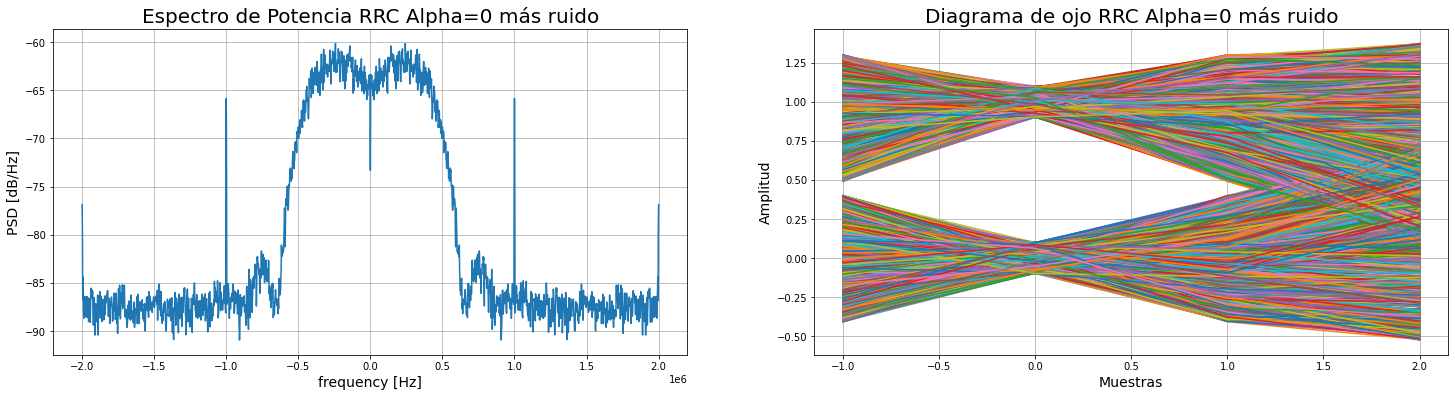

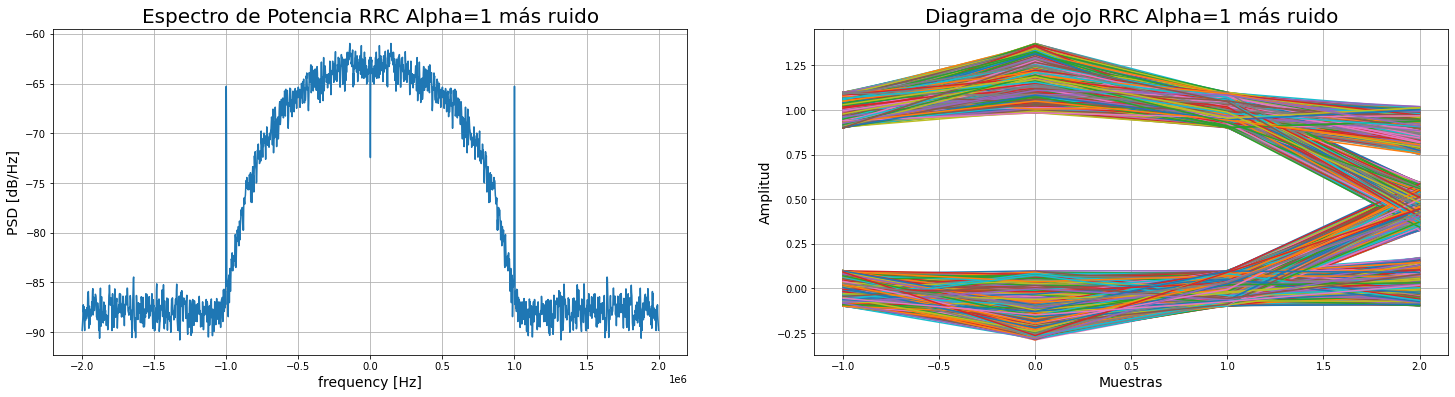

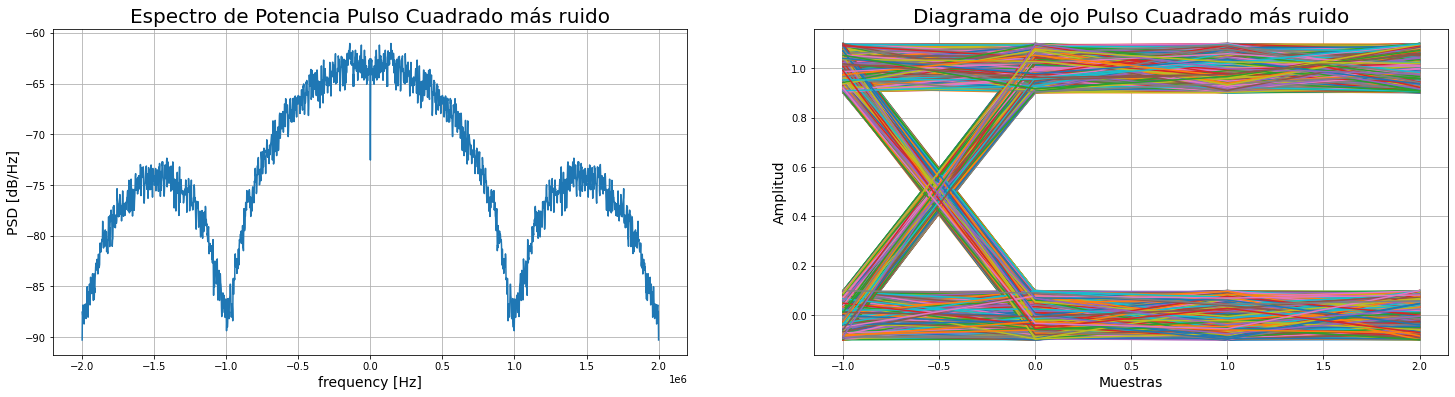

In [11]:
magnitud=0.2
s_RRC+= magnitud*np.random.rand(len(s_RRC))-magnitud/2
s_RRC2+= magnitud*np.random.rand(len(s_RRC2))-magnitud/2
s_ps+= magnitud*np.random.rand(len(s_ps))-magnitud/2
Grafica_PSD_eyediagram(s_RRC,Fs,muestras_simbolo,title='RRC Alpha=0 más ruido')
Grafica_PSD_eyediagram(s_RRC2,Fs,muestras_simbolo,title='RRC Alpha=1 más ruido')
Grafica_PSD_eyediagram(s_ps,Fs,muestras_simbolo,title='Pulso Cuadrado más ruido')

# Multi Nivel

[1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0]
[2 1 2 1 2 1 0 3 0]


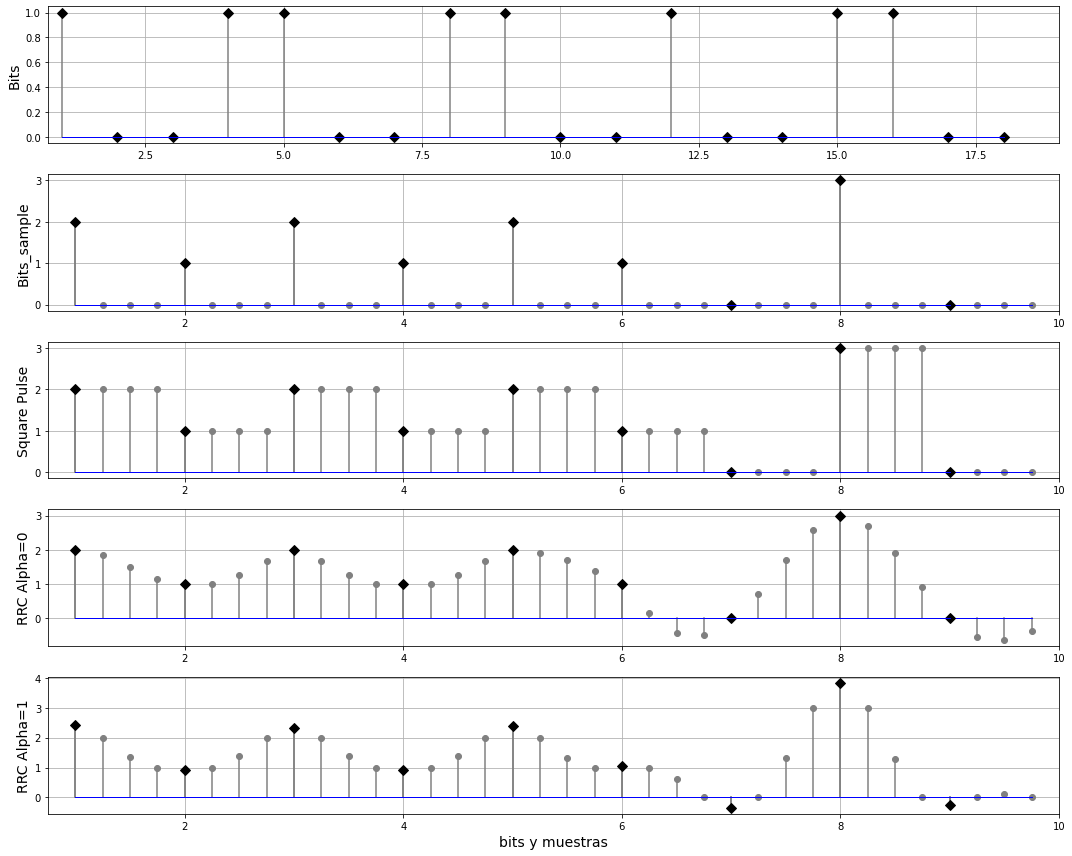

In [43]:
Nbits = 18 #numero de bits
Nbitsagrupados = 2 # Cuantos bits se van a agrupar 
Nmuestras = ceil(Nbits/Nbitsagrupados)
bits = np.random.randint(0,2,Nbits) #Señal binaria de 6 bits
mnivel = bintodecimal(bits,Nbitsagrupados,relleno='despues')
#bits = np.ones(Nbits)  para solo 1
bits_sample = upsample(mnivel, muestras_simbolo)
t_s = np.linspace(1,Nbits+(muestras_simbolo-1)/muestras_simbolo,Nbits*muestras_simbolo)
t_b = range(1,len(bits)+1)

s_ps = np.convolve(bits_sample,ps)[int(muestras_simbolo):-int(muestras_simbolo*2-1)]
inicial= int(longitud_filtro_s/2*muestras_simbolo)
final = -(inicial-1)
s_RRC = np.convolve(bits_sample,RRC[1])[inicial:final]
s_RRC2 = np.convolve(bits_sample,RRC2[1])[inicial:final]
print(bits)
print(mnivel)

fig = plt.figure(figsize=(15,12))

################## Primer plot Bits ##########################################
plt.subplot(5,1,1)
markerline, stemlines, baseline =plt.stem(t_b, bits, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')
plt.ylabel('Bits',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nbits+1))
plt.grid()


#################  Segundo plot bits sampleados y cuantificados #########################################
t_s = np.linspace(1,Nmuestras+(muestras_simbolo-1)/muestras_simbolo,Nmuestras*muestras_simbolo)
t_b = range(1,len(mnivel)+1)

plt.subplot(5,1,2)
markerline, stemlines, baseline =plt.stem(t_s, bits_sample, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= bits_sample[np.linspace(0,muestras_simbolo*(Nmuestras-1),Nmuestras).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.ylabel('Bits_sample',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nmuestras+1))
plt.grid()

##################### Tercer plot pulsos cuadrados ############################################
plt.subplot(5,1,3)
markerline, stemlines, baseline =plt.stem(t_s, s_ps, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_ps[np.linspace(0,muestras_simbolo*(Nmuestras-1),Nmuestras).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.ylabel('Square Pulse',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nmuestras+1))
plt.grid()


####################### Cuarto plot RRC alpha=0 ######################################################
plt.subplot(5,1,4)
markerline, stemlines, baseline =plt.stem(t_s, s_RRC, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_RRC[np.linspace(0,muestras_simbolo*(Nmuestras-1),Nmuestras).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')
plt.ylabel(r'RRC Alpha=0',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nmuestras+1))
plt.grid()

fig.tight_layout()

####################### Cuarto plot RRC alpha=1 ######################################################

plt.subplot(5,1,5)
markerline, stemlines, baseline =plt.stem(t_s, s_RRC2, linefmt ='gray')
plt.setp(baseline, 'linewidth', 1,'color','blue')
markerline.set_markerfacecolor('gray') 
markerline.set_markeredgecolor('gray')

muestras_iniciales= s_RRC2[np.linspace(0,muestras_simbolo*(Nmuestras-1),Nmuestras).astype('int')]
markerline, stemlines, baseline =plt.stem(t_b, muestras_iniciales, linefmt ='gray', markerfmt ='D')
plt.setp(baseline, 'linewidth', 1,'color','blue')
plt.setp(markerline, markersize=7)
markerline.set_markerfacecolor('black') 
markerline.set_markeredgecolor('black')

plt.xlabel('bits y muestras',fontsize = 14)
plt.ylabel(r'RRC Alpha=1',fontsize = 14)
plt.xlim(((muestras_simbolo-1)/muestras_simbolo,Nmuestras+1))
plt.grid()

fig.tight_layout()

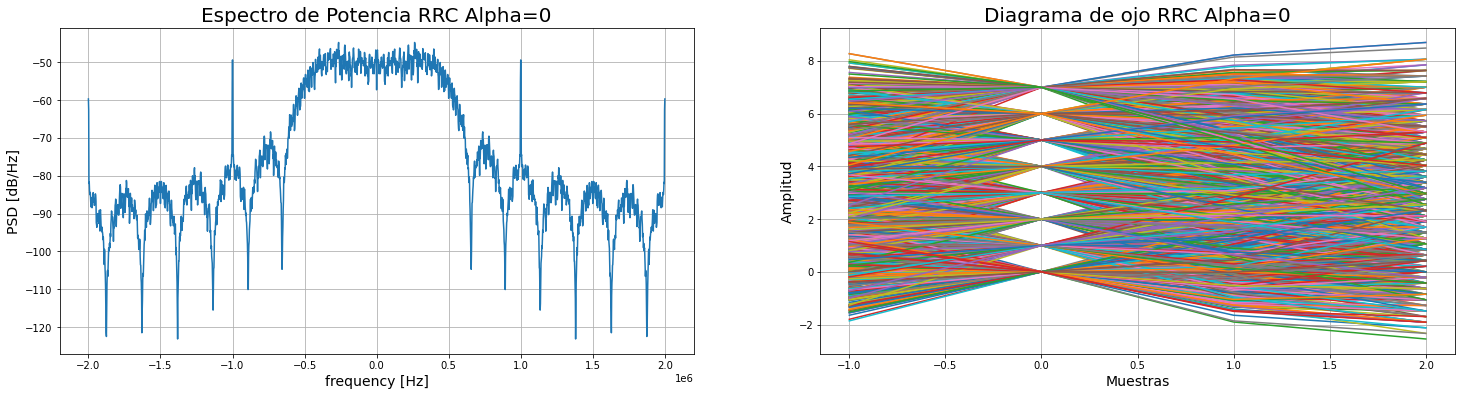

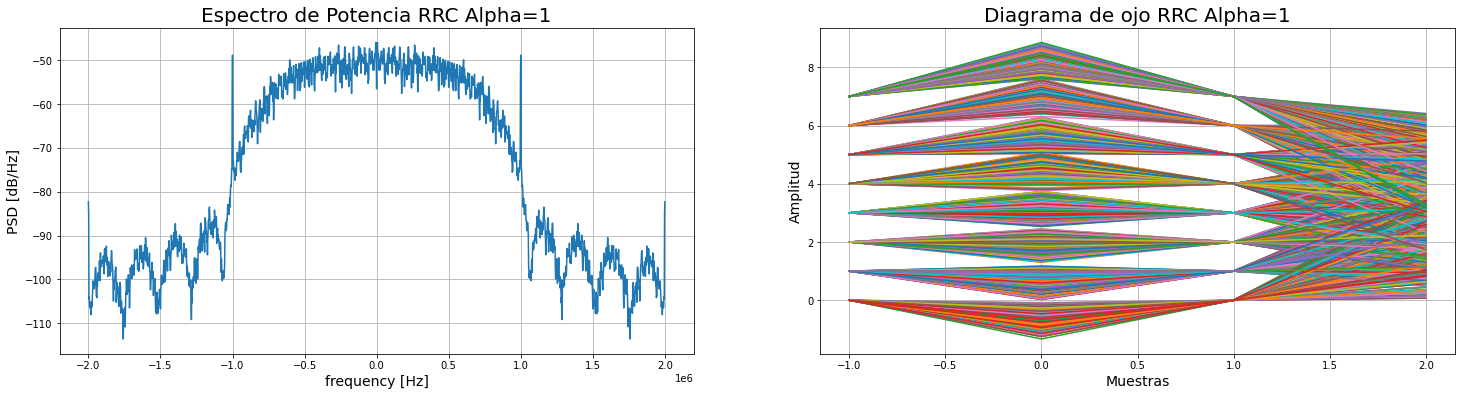

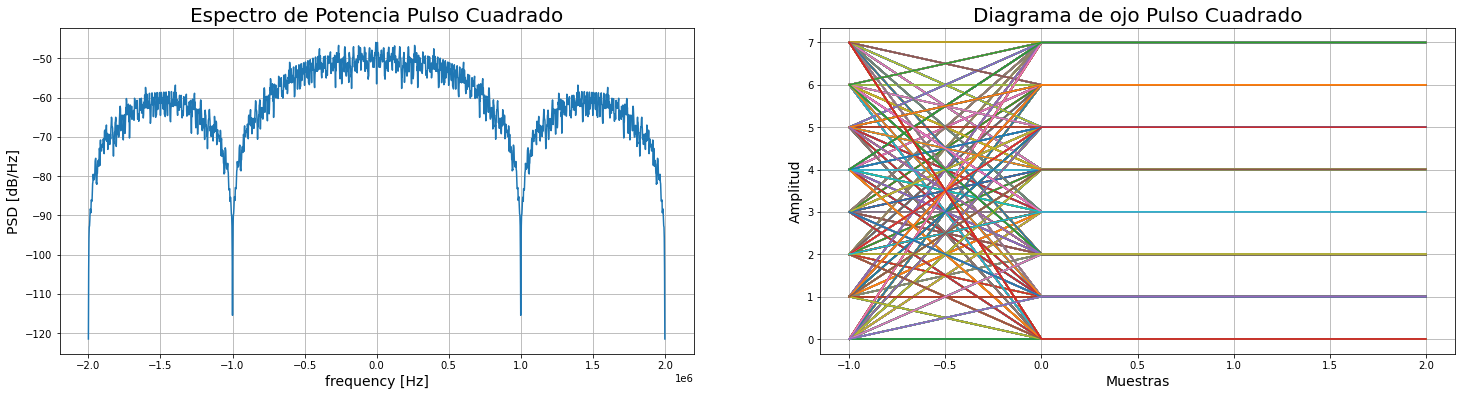

In [53]:
Nbits = 5000 #numero de bits
Nbitsagrupados = 3 # Cuantos bits se van a agrupar 
bits = np.random.randint(0,2,Nbits) #Señal binaria de N bits
Nmuestras = ceil(Nbits/Nbitsagrupados)
#bits = np.ones(Nbits)  para solo 1
mnivel = bintodecimal(bits,Nbitsagrupados,relleno='despues')
bits_sample = upsample(mnivel, muestras_simbolo)

t_s = np.linspace(1,Nmuestras+(muestras_simbolo-1)/muestras_simbolo,Nmuestras*muestras_simbolo)
t_b = range(1,len(mnivel)+1)

s_ps = np.convolve(bits_sample,ps)[int(muestras_simbolo):-int(muestras_simbolo*2-1)]
inicial= int(longitud_filtro_s/2*muestras_simbolo)
final = -(inicial-1)
s_RRC = np.convolve(bits_sample,RRC[1])[inicial:final]
s_RRC2 = np.convolve(bits_sample,RRC2[1])[inicial:final]

Fs = 1e6*muestras_simbolo  

Grafica_PSD_eyediagram(s_RRC,Fs,muestras_simbolo,title='RRC Alpha=0')
Grafica_PSD_eyediagram(s_RRC2,Fs,muestras_simbolo,title='RRC Alpha=1')
Grafica_PSD_eyediagram(s_ps,Fs,muestras_simbolo,title='Pulso Cuadrado')

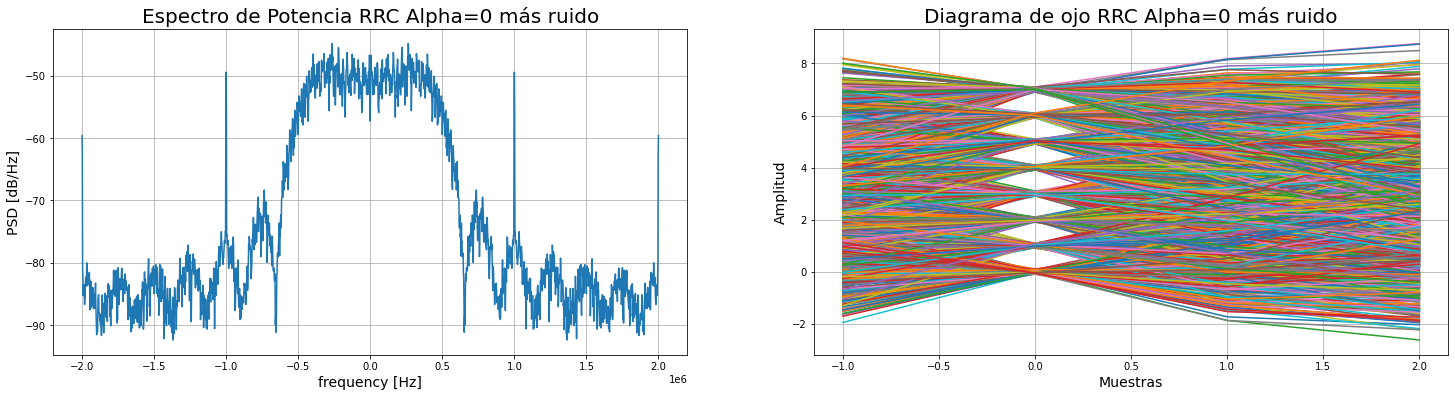

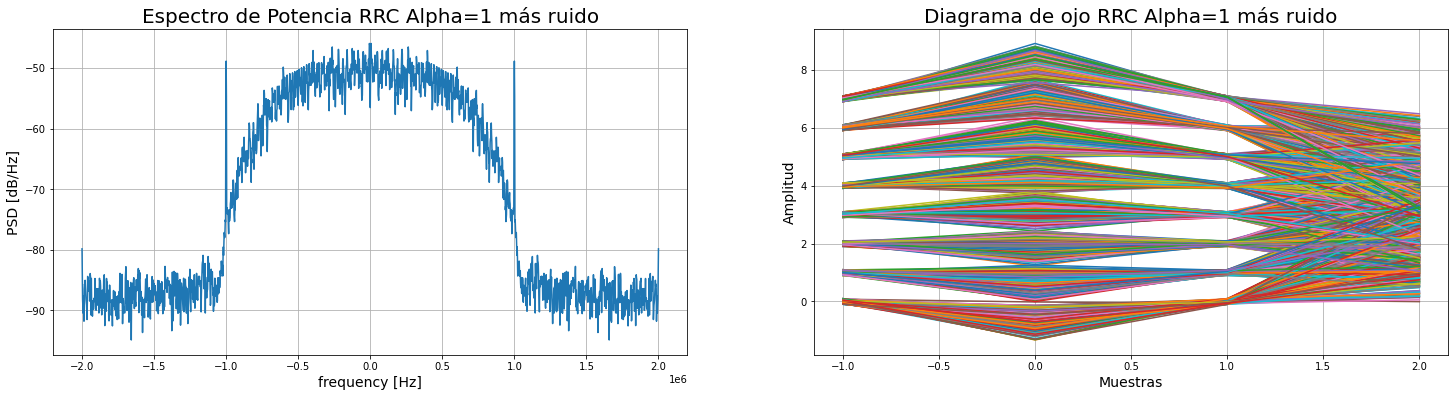

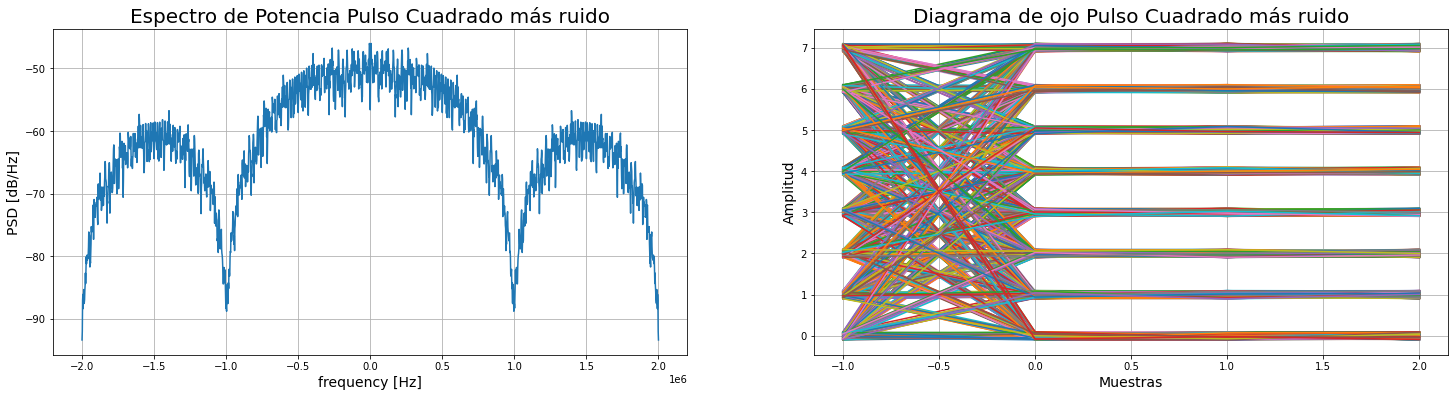

In [54]:
magnitud=0.2
s_RRC+= magnitud*np.random.rand(len(s_RRC))-magnitud/2
s_RRC2+= magnitud*np.random.rand(len(s_RRC2))-magnitud/2
s_ps+= magnitud*np.random.rand(len(s_ps))-magnitud/2
Grafica_PSD_eyediagram(s_RRC,Fs,muestras_simbolo,title='RRC Alpha=0 más ruido')
Grafica_PSD_eyediagram(s_RRC2,Fs,muestras_simbolo,title='RRC Alpha=1 más ruido')
Grafica_PSD_eyediagram(s_ps,Fs,muestras_simbolo,title='Pulso Cuadrado más ruido')

In [62]:
@interact(Alpha=(0, 1, 0.1),mues_sim=(2, 12, 1),P_Shaping=['Square','RRC'],ruido=(0, 1, 0.1),NbitAgrupados=(1, 5, 1),L_fil=(2, 12, 2))
def r(mues_sim=8,Alpha=0,P_Shaping='RRC',ruido=0,NbitAgrupados=2,L_fil=6):
  muestras_simbolo=mues_sim
  muestras_simbolo=mues_sim
  Nbits = 5000
  Nbitsagrupados = NbitAgrupados
  bits = np.random.randint(0,2,Nbits)
  Nmuestras = ceil(Nbits/Nbitsagrupados)
  mnivel = bintodecimal(bits,Nbitsagrupados,relleno='despues')
  bits_sample = upsample(mnivel, muestras_simbolo)
  magnitud=ruido
  t_s = np.linspace(1,Nmuestras+(muestras_simbolo-1)/muestras_simbolo,Nmuestras*muestras_simbolo)
  t_b = range(1,len(mnivel)+1)

  if P_Shaping=='Square':

    ps = np.concatenate((np.zeros(muestras_simbolo),np.ones(muestras_simbolo),np.zeros(muestras_simbolo)))
    signal = np.convolve(bits_sample,ps)[int(muestras_simbolo):-int(muestras_simbolo*2-1)]

  if P_Shaping=='RRC':
    longitud_filtro_s= L_fil 
    longitud_filtro_m = longitud_filtro_s*muestras_simbolo  
    alpha = Alpha 
    Ts =1 
    Fs = muestras_simbolo/Ts  

    RRC = rrcosfilter(longitud_filtro_m, alpha=alpha, Ts=Ts, Fs=Fs)
    inicial= int(longitud_filtro_s/2*muestras_simbolo)
    final = -(inicial-1)
    signal = np.convolve(bits_sample,RRC[1])[inicial:final]

  Fs = 1e6*muestras_simbolo  
  signal += magnitud*np.random.rand(len(signal))-magnitud/2
  Grafica_PSD_eyediagram(signal,Fs,muestras_simbolo,title=P_Shaping)


interactive(children=(IntSlider(value=8, description='mues_sim', max=12, min=2), FloatSlider(value=0.0, descri…